In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hoho-criteo/README.md
/kaggle/input/hoho-criteo/Experiments.ipynb
/kaggle/input/hoho-criteo/criteo-dataset-description.docx
/kaggle/input/hoho-criteo/criteo_attribution_dataset.tsv/pcb_dataset_final.tsv
/kaggle/input/hoho-criteo/criteo/train_usr.yzx.txt
/kaggle/input/hoho-criteo/criteo/test_usr.yzx.txt


In [7]:
!nvidia-smi

Tue Jul 25 11:18:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [9]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

# 还是没法理解这个类别平衡是怎么实现的
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [10]:
data_file = '/kaggle/input/hoho-criteo/criteo_attribution_dataset.tsv/pcb_dataset_final.tsv'
df0 = pd.read_csv(data_file, sep='\t', nrows = 500000)

In [11]:
n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [12]:
df6.sample(5)

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
1702,15441,10643822,28795042,0,-1,-1,0,1,-1,-1,...,32440044,1973606,12195854,3225256,6083947,10643822_-1,0.209106,0.000335,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3646,55648,28755553,13365547,1,757899,13714310,0,1,11,14,...,11409684,1973606,26058804,9068204,22419790,28755553_13714310,0.753599,0.000048,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4645,24784,14089287,27091101,1,743016,17258758,0,1,2,4,...,32440044,32440044,9312274,29196072,8661623,14089287_17258758,0.335631,0.227346,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
379,16133,6072740,32135670,0,-1,-1,0,1,-1,-1,...,32440044,28928366,9312274,29196072,358246,6072740_-1,0.218477,0.000021,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3435,39627,22478271,9100693,1,40350,1089295,1,1,0,2,...,26611395,28928366,11974250,29196072,29520626,22478271_1089295,0.536639,0.065062,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


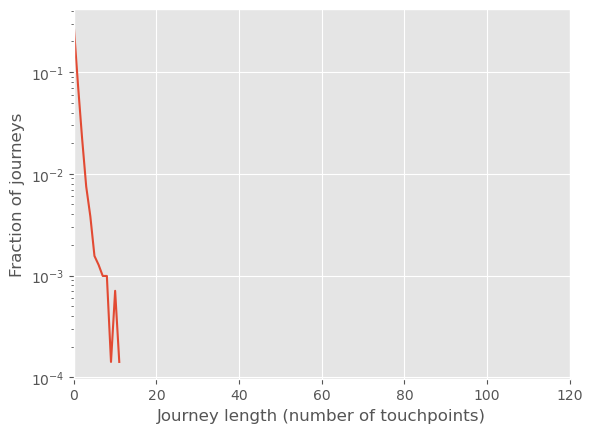

In [13]:
def journey_length_histogram(df):
    counts = df.groupby(["jid"])["uid"].count().reset_index(name = "count").groupby(["count"]).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_histogram(df4)

plt.plot(range(len(hist_x)), hist_y, label = "all journeys")
plt.yscale("log")
plt.xlim(0, 120)
plt.xlabel("Journey length (number of touchpoints)")
plt.ylabel("Fraction of journeys")
plt.show()

In [14]:
def last_touch_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters

    campaign_impressions = count_by_campaign(df)  # 每个活动的次数
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm'] #找到时间戳最大那行，即最近转化的那行，即找到最后触达的渠道
    campaign_conversions = count_by_campaign(df_converted[idx])
    
    result = np.zeros(n_campaigns)
    idx = 0
    for idx, (conversion, impression) in enumerate(zip(campaign_conversions, campaign_impressions)):
        if impression == 0:
            result[idx] = 0.0
        else:
            result[idx] = conversion / impression
    return result
#     return campaign_conversions / campaign_impressions  
    

In [15]:
lta = last_touch_attribution(df6) # LTA模型进行归因分析

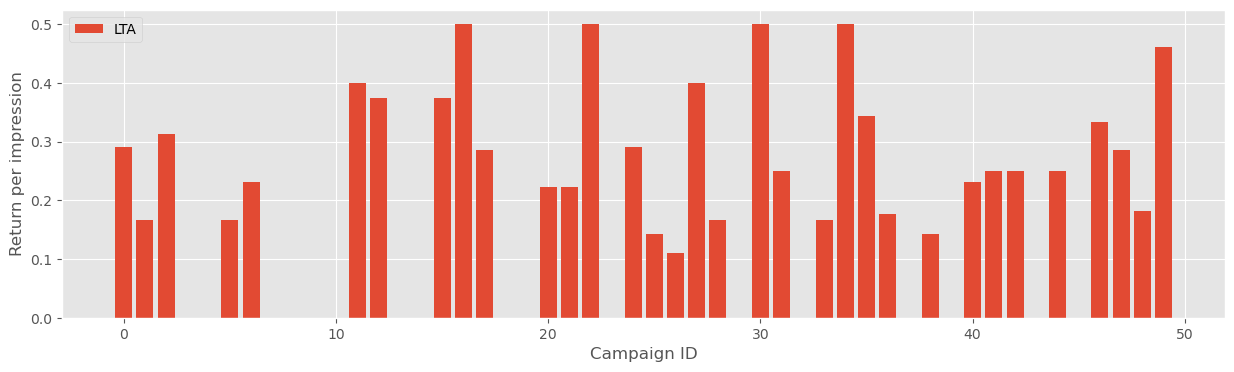

In [16]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)
# campaign_idx = range(lta.shape[0])

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [17]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
 
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [18]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(2826, 992)


In [19]:
print(y.shape)

(2826,)


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [22]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8621908127208481


In [23]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: tensorflow


In [24]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
15/15 [==============================] - 2s 17ms/step - loss: 0.7078 - accuracy: 0.4364 - val_loss: 0.6969 - val_accuracy: 0.5044
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5277 - val_loss: 0.6827 - val_accuracy: 0.5796
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.6256 - val_loss: 0.6693 - val_accuracy: 0.6504
Epoch 4/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6559 - accuracy: 0.6842 - val_loss: 0.6572 - val_accuracy: 0.6792
Epoch 5/10
15/15 [==============================] - 0s 6ms/step - loss: 0.6416 - accuracy: 0.7262 - val_loss: 0.6452 - val_accuracy: 0.7058
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6276 - accuracy: 0.7622 - val_loss: 0.6335 - val_accuracy: 0.7235
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: 0.6147 - accuracy: 0.7721 - val_loss: 0.6227 - val_accuracy: 0.7367
Epoch 8/10
15/15 [=

In [23]:
# pytorch形式

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Assuming 'x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test' are your training, validation, and testing data
# Make sure they are converted to torch tensors or numpy arrays before proceeding.

class ContributionsModel(nn.Module):
    def __init__(self, input_dim):
        super(ContributionsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

input_dim = np.shape(x_train)[1]
model = ContributionsModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters())

# Convert the data to torch tensors if they are not already in that format
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = torch.unsqueeze(y_train, 1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = torch.unsqueeze(y_val, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = torch.unsqueeze(y_test, 1)

print(f"input size: {x_train.shape}, target size: {y_train.shape}")

# Training loop
batch_size = 128
epochs = 10
num_batches = len(x_train) // batch_size

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        inputs, targets = x_train[start_idx:end_idx], y_train[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs, y_test)
    test_accuracy = ((test_outputs >= 0.5) == y_test).float().mean()

print('Test loss:', test_loss.item())
print('Test accuracy:', test_accuracy.item())


input size: torch.Size([2749, 1031]), target size: torch.Size([2749, 1])
Epoch 1/10, Loss: 0.4764
Epoch 2/10, Loss: 0.3759
Epoch 3/10, Loss: 0.3487
Epoch 4/10, Loss: 0.3334
Epoch 5/10, Loss: 0.3231
Epoch 6/10, Loss: 0.3156
Epoch 7/10, Loss: 0.3097
Epoch 8/10, Loss: 0.3050
Epoch 9/10, Loss: 0.3010
Epoch 10/10, Loss: 0.2975
Test loss: 0.3430531322956085
Test accuracy: 0.8662790656089783


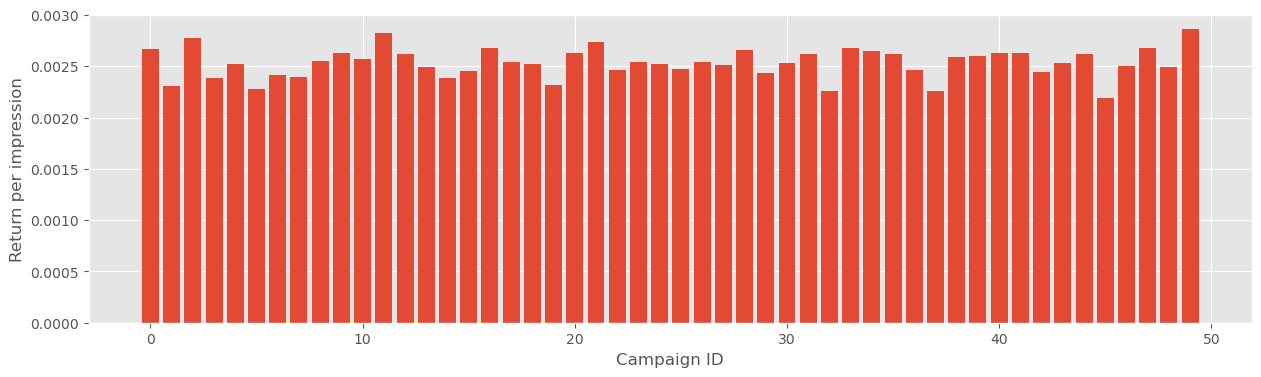

In [25]:
# # Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# 用普通的一层神经网络的归因分析，网络的权重即每个渠道的贡献度
# model.eval()
# with torch.no_grad():
#     weights = model.fc1.weight.squeeze().detach().numpy()  # Get the model's weights and convert to numpy
# #     print(f"weights: {weights}")
#     weights = weights[np.newaxis, :]
# #     print(f"2. weights: {weights}")
#     keras_logreg = softmax(weights)[0:n_campaigns].flatten()

# fig = plt.figure(figsize=(15,4))
# ax = fig.add_subplot(111)
# plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
# plt.xlabel('Campaign ID')
# plt.ylabel('Return per impression')
# plt.show()

In [26]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
#     print(f"x2d: {x2d}")
#     print(f"cumsum: {np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])[1]}")
    
    # 将x2d划分为一行一个样本，每个样本包含这些特征：'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion'
    # 其实直接将x2d除第1列之外的特征提取出来不就行了？！绕来绕去的
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1]) 
    
#     print(f"x3d_list: {x3d_list[0]}")
    
    x3d = []
    y = []
    
    for idx, xi in enumerate(x3d_list):
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi) 
        # 把xi水平拉平为一行数值特征（原本每个特征维度是分开的）
        # 注意：journey_matrix依然是二维的
        
#         if idx == 0:
#             print(f"xi: {xi}")
#             print(f"journey_matrix: {journey_matrix}")
#             print(f"argsort: {journey_matrix[:, 5].argsort() }")
#             print(f"argsorted: {journey_matrix[ journey_matrix[:, 5].argsort() ] }")
        
        
        journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        # 这里有问题吧：已经将数组拉平了，第5个位置就不是timestamp了，倒数第2个索引才是
        
        n_touchpoints = len(journey_matrix)
        
#         if idx == 0:
#             print(f"n_touchpoints: {n_touchpoints}")
        
        
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
        
#         if idx == 0:
#             print(f"padded_journey: {padded_journey}")
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y



In [27]:
#demo
_, _ = features_for_lstm(df6.sample(10), 3)

In [28]:
x, y = features_for_lstm(df6, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

# 注意：这里有坑，要转为numpy数组
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

(2826, 15, 994)


In [1]:
# 普通LSTM

from keras.models import Sequential 
from keras.layers import Dense, LSTM
import numpy as np

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, np.array(y_train), batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

NameError: name 'x' is not defined

In [81]:
### 用pytorch实现

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming x_train, y_train, x_val, y_val, x_test, and y_test are available

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Select only the output of the last time step
        out = self.fc(out)
        out = torch.sigmoid(out)  # Apply sigmoid activation for binary classification
        return out

# Define the hyperparameters
n_steps, n_features = x_train.shape[1:]

# Instantiate the model
hidden_size = 64
output_size = 1
model = LSTMModel(n_features, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters())

# Training loop
batch_size = 64
epochs = 5

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Test the model
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_accuracy = ((test_outputs >= 0.5) == y_test).float().mean()


print('Test Loss:', test_loss.item())
print('Test accuracy: ', test_accuracy.item())


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Loss: 0.6568, Val Loss: 0.6680
Epoch [2/5], Loss: 0.6542, Val Loss: 0.6674
Epoch [3/5], Loss: 0.6529, Val Loss: 0.6672
Epoch [4/5], Loss: 0.6521, Val Loss: 0.6672
Epoch [5/5], Loss: 0.6515, Val Loss: 0.6672
Test Loss: 0.6624795794487
Test accuracy:  0.6232876777648926


In [29]:
# LSTM with Attention

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]
print(f"x: {x.shape}")

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)
print(f"embeddings: {embeddings.shape}")

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)
print(f"LSTM|activations: {activations.shape}")

attention = Dense(1, activation='tanh')(activations)
print(f"Dense|attention: {attention.shape}")

attention = Flatten()(attention)
print(f"Flatten|attention: {attention.shape}")

attention = Activation('softmax', name = 'attention_weigths')(attention)  # 对每个渠道作归一化
print(f"Activation|attention: {attention.shape}")

attention = RepeatVector(hidden_units * 1)(attention)
print(f"RepeatVector|attention: {attention.shape}")

attention = Permute([2, 1])(attention)
print(f"Permute|attention: {attention.shape}")

weighted_activations = Multiply()([activations, attention])  # activations是LSTM的输出
print(f"Multiply|weighted_activations: {weighted_activations.shape}")

weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)
print(f"sum|weighted_activations: {weighted_activations.shape}")

main_output = Dense(1, activation='sigmoid')(weighted_activations)
print(f"main_output: {main_output.shape}")

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

x: (2826, 15, 994)
embeddings: (None, 15, 128)
LSTM|activations: (None, 15, 64)
Dense|attention: (None, 15, 1)
Flatten|attention: (None, 15)
Activation|attention: (None, 15)
RepeatVector|attention: (None, 64, 15)
Permute|attention: (None, 15, 64)
Multiply|weighted_activations: (None, 15, 64)
sum|weighted_activations: (None, 64)
main_output: (None, 1)
Epoch 1/10
29/29 [==============================] - 6s 94ms/step - loss: 0.5432 - accuracy: 0.7118 - val_loss: 0.3151 - val_accuracy: 0.8695
Epoch 2/10
29/29 [==============================] - 2s 83ms/step - loss: 0.2592 - accuracy: 0.8993 - val_loss: 0.2345 - val_accuracy: 0.9093
Epoch 3/10
29/29 [==============================] - 2s 79ms/step - loss: 0.2151 - accuracy: 0.9181 - val_loss: 0.2161 - val_accuracy: 0.9181
Epoch 4/10
29/29 [==============================] - 2s 80ms/step - loss: 0.1960 - accuracy: 0.9275 - val_loss: 0.2015 - val_accuracy: 0.9181
Epoch 5/10
29/29 [==============================] - 2s 77ms/step - loss: 0.1795 - a

In [91]:
# pytorch形式
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming 'x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test' are the training, validation, and test data arrays

    
class AttentionLSTM(nn.Module):
    def __init__(self, n_steps, n_features, hidden_units):
        super(AttentionLSTM, self).__init__()
        
        self.hidden_units = hidden_units
        self.embeddings = nn.Linear(n_features, 128)
        self.lstm = nn.LSTM(128, hidden_units, dropout=0.2, batch_first=True)
        self.attention = nn.Linear(hidden_units, 1)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        self.multiply = torch.mul
        self.sum = torch.sum
        self.output_layer = nn.Linear(hidden_units, 1)

    def forward(self, x):
#         print(f"x: {x.shape}")
        
        embeddings = self.embeddings(x)
#         print(f"embeddings: {embeddings.shape}")
        
        activations, _ = self.lstm(embeddings)
#         print(f"lstm|activations: {activations.shape}")
        
        attention = self.attention(activations)
#         print(f"attention|attention: {attention.shape}")
        
        attention = self.flatten(attention)
#         print(f"flatten|attention: {attention.shape}")
        
        attention = self.softmax(attention)
#         print(f"softmax|attention: {attention.shape}")
        
        attention = attention.unsqueeze(2)
#         print(f"unsqueeze|attention: {attention.shape}")
        
        attention = torch.repeat_interleave(attention, repeats = self.hidden_units, axis = 2)
#         print(f"repeat|attention: {attention.shape}")
        

        weighted_activations = self.multiply(activations, attention)
#         print(f"multiply|weighted_activations: {weighted_activations.shape}")
        
        weighted_activations = self.sum(weighted_activations, dim=1)
#         print(f"sum|weighted_activations: {weighted_activations.shape}")

        main_output = self.output_layer(weighted_activations)
#         print(f"output_layer|main_output: {main_output.shape}")
        
        main_output = torch.sigmoid(main_output)
#         print(f"sigmoid|main_output: {main_output.shape}")
        
        return main_output

n_steps, n_features = x_train.shape[1:3]
hidden_units = 64

model = AttentionLSTM(n_steps, n_features, hidden_units)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

def train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs=5, batch_size=64):
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
#             print(f"outputs: {outputs.squeeze().shape}, {batch_y.shape}")
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs.squeeze(), y_val)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss.item():.4f}')

train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs=10)

model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_accuracy = ((torch.sigmoid(test_outputs) > 0.5).float() == y_test).float().mean().item()

print('Test Loss:', test_loss.item())
print('Test Accuracy:', test_accuracy)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Validation Loss: 0.6612
Epoch 2/10, Validation Loss: 0.5858
Epoch 3/10, Validation Loss: 0.5432
Epoch 4/10, Validation Loss: 0.5461
Epoch 5/10, Validation Loss: 0.5471
Epoch 6/10, Validation Loss: 0.5251
Epoch 7/10, Validation Loss: 0.5275
Epoch 8/10, Validation Loss: 0.5250
Epoch 9/10, Validation Loss: 0.5227
Epoch 10/10, Validation Loss: 0.5226
Test Loss: 0.5060881972312927
Test Accuracy: 0.6232876777648926


In [72]:
# 为什么同样的神经网络架构，这里使用keras效果比pytorch要好？

In [30]:
model.input

<KerasTensor: shape=(None, 15, 994) dtype=float32 (created by layer 'input_1')>

In [33]:
# Analysis of LSTM-A Model
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)
print(f"input shape: {x_train.shape}")
print(f"attentions shape: {a.shape}")

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

57/57 [==============================] - 1s 6ms/step
input shape: (1808, 15, 994)
attentions shape: (1808, 15)


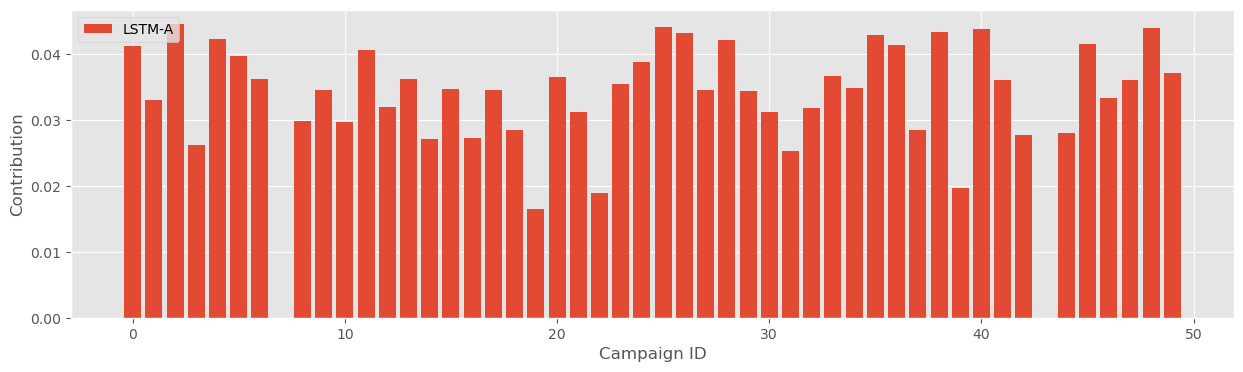

In [34]:
lstm_a = (attributions/campaign_freq)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

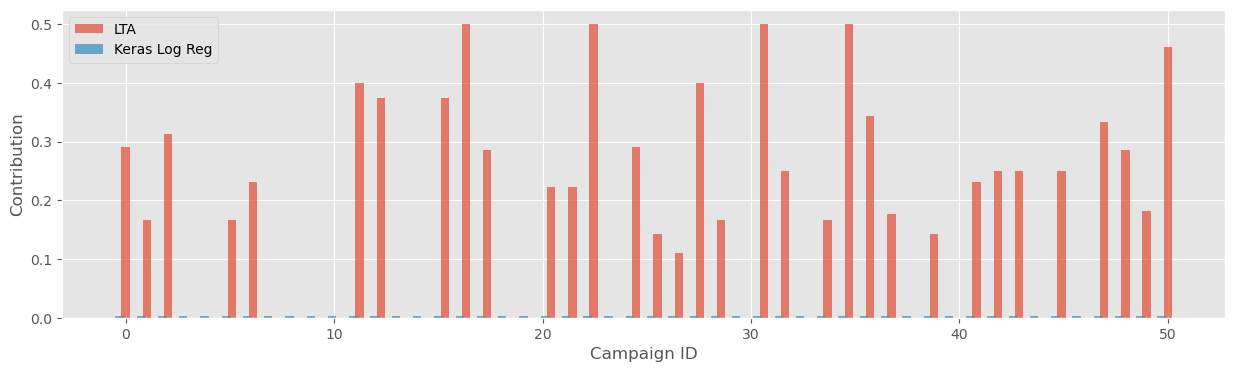

In [36]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, keras_logreg[campaign_idx], width=0.4, alpha=0.7, label='Keras Log Reg' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

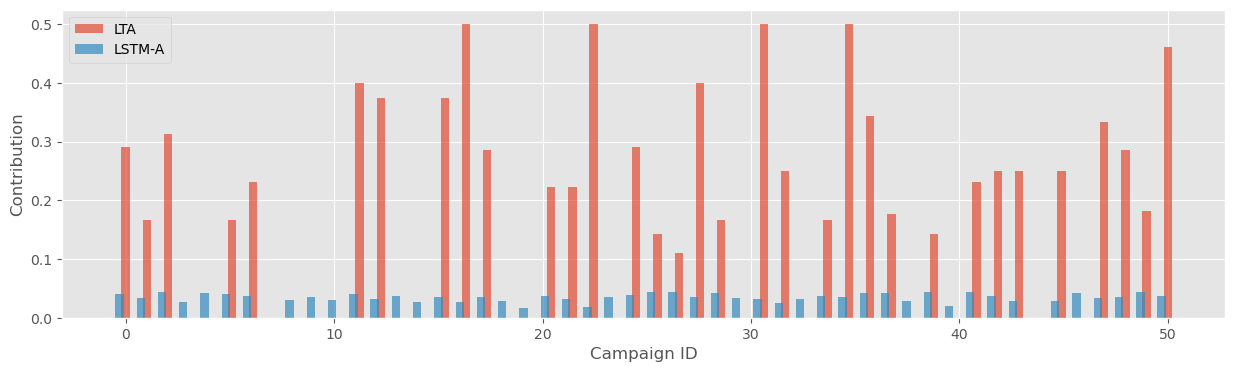

In [37]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(lstm_a[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lstm_a[campaign_idx], width=0.4, alpha=0.7, label='LSTM-A'  )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

In [38]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    # 根据归因值 attribution 将总预算 budget_total 分配给各个活动，并向上取整得到 budgets 数组，表示每个活动可用的预算上限
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:  # 大于1表示该活动还有预算
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):  # 为什么要乘以0.02
            break
            
    return len(conversions.difference(blacklist))

In [43]:

pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg, lstm_a]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch, verbose = True)
        print('{} {} : {}'.format(i, j, reward))

[37. 43. 43. 42. 41. 42. 40. 41. 42. 40. 38.  0. 42. 41. 38. 36. 42. 40.
 41. 39. 43. 38. 40. 41. 40. 40.  0. 40. 38. 37. 43. 43. 42. 44. 43. 41.
 42. 41. 39. 42. 42. 42. 39. 38. 37. 41. 42. 40. 43.  0. 43. 38. 43. 41.
 39. 41. 40. 38. 40. 40. 41. 39. 42. 42.  0. 39. 37. 42. 40. 37.  0. 36.
 39. 39. 35. 45. 44. 39. 41. 41. 41.  0. 42. 40. 41. 37. 37. 36. 42. 38.
 42. 39. 38. 36. 41. 39. 42. 42.  0. 43. 44. 37. 44. 35. 40. 42. 40. 43.
 38. 45. 42. 43. 38. 45. 44. 39.  0. 40. 42. 45. 44. 38.  0. 41. 39. 39.
  0. 37. 41. 43. 42.  0.  0. 39. 38. 43. 41. 40. 42.  0. 39. 43. 38.  0.
 44. 42. 39. 42. 41.  0. 42. 40. 43.  0.  0. 40. 42.  0.  0.  0.  0. 44.
 44.  0.  0. 44. 45. 42.  0.  0. 41. 41. 45.  0. 42. 40. 39. 44. 40.  0.
 45. 42.  0. 40. 45. 43. 40.  0. 40.  0. 42. 42. 42.  0. 42.  0. 43. 42.
 41. 44. 36. 45. 40. 37. 40. 35.  0. 45.  0. 44.  0. 43. 43. 42.  0. 38.
 43. 44. 42. 44. 43. 39. 43.  0. 44. 42. 44. 44.  0. 40. 40.  0. 42. 43.
 45.  0.  0. 43. 40. 41. 42. 45. 45. 39.  0. 41. 40